In [102]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
# Load training data
train_data_import = pd.read_csv("../TrainingData/neodata/fault_all_1000.csv")
train_data_import.sample(frac=1).head()

,Pdis,Psuc,T0,Tc,Tdis,Tret,Tsuc,Tsh,Tsup,CondFan,CprPower,Density,Tamb,Tset,target
259650,9.482772,2.731211,-1.905262,37.428505,62.053574,18.090536,11.674050,13.579312,7.000014,100.000000,4210.262338,6.036841,10,7,14
157990,9.589694,2.683663,-2.381332,37.839958,61.586563,18.298985,11.790431,14.171762,6.999962,100.000000,4491.410758,5.929966,20,7,8
374963,12.563877,3.161136,2.133028,48.109453,70.996460,24.397324,16.551950,14.418920,11.997366,30.000000,5671.433843,6.930429,30,12,20
298130,9.539964,3.450928,4.622477,37.648997,69.643612,21.879612,19.623501,15.000975,10.615388,100.000000,4226.702582,7.527388,20,7,16
318000,8.240961,6.341307,23.393346,32.373648,32.321827,39.730165,38.412952,15.018249,31.516890,59.707195,50.175731,13.432594,30,0,17


In [104]:
train_data = train_data_import.copy()

----
# Linear Discriminant Analysis of data
----

In [105]:
# Config

train_data = train_data_import.copy()

sigma = 0.0001

ignore_features = []
ignore_targets = []

# ignore_features = ["Tamb"]
# ignore_targets = [17,18,19]

features = train_data_import.columns.to_list()
targets = train_data_import['target'].unique().tolist()

# Remove unwanted
for i in ignore_targets:
    targets.remove(i)
    
for i in ignore_features:
    train_data.pop(i)

In [106]:
# Temporarily remove target column
target = train_data.pop('target')

# Normalization / conditioning
norm_fact = (train_data.sum()/len(train_data))
train_data = train_data / norm_fact
# train_data -= train_data.mean()

# Add gaussian noise
train_data += np.random.randn(train_data.shape[0],train_data.shape[1])*sigma

# Reapply taget column
train_data = train_data.assign(target=target)

In [107]:
train_data.head()

,Pdis,Psuc,T0,Tc,Tdis,Tret,Tsuc,Tsh,Tsup,CondFan,CprPower,Density,Tamb,Tset,target
0,0.893883,0.830483,-1.623732,0.889782,0.917984,0.279948,0.260899,0.545063,0.000521,0.633854,0.441361,0.847244,0.499762,0.000102,0
1,0.893891,0.830359,-1.623654,0.889739,0.918236,0.280007,0.260801,0.544881,0.000642,0.633875,0.441481,0.847293,0.500022,-0.000108,0
2,0.894053,0.830401,-1.623740,0.889643,0.918055,0.279862,0.261031,0.545114,0.000665,0.633801,0.441360,0.847010,0.500071,-0.000065,0
3,0.893897,0.830336,-1.623843,0.889817,0.918185,0.280007,0.260838,0.545112,0.000772,0.633854,0.441137,0.847169,0.500126,0.000236,0
4,0.893705,0.830413,-1.623770,0.889586,0.918253,0.280029,0.260921,0.545087,0.000659,0.633836,0.441267,0.847114,0.500026,-0.000026,0


----
# Dimensionality reduction using LDA

Preserving 100.0% of variance


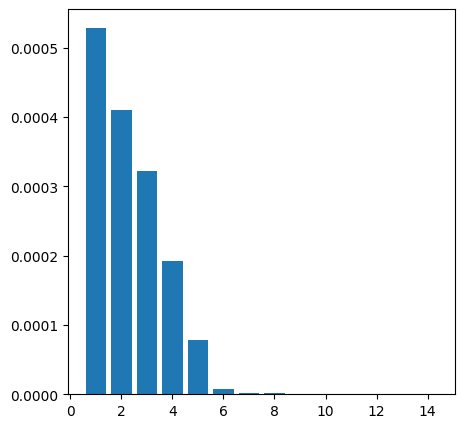

In [108]:
from lda import LDA_reducer as reducer
lda = reducer(train_data,13,'target')

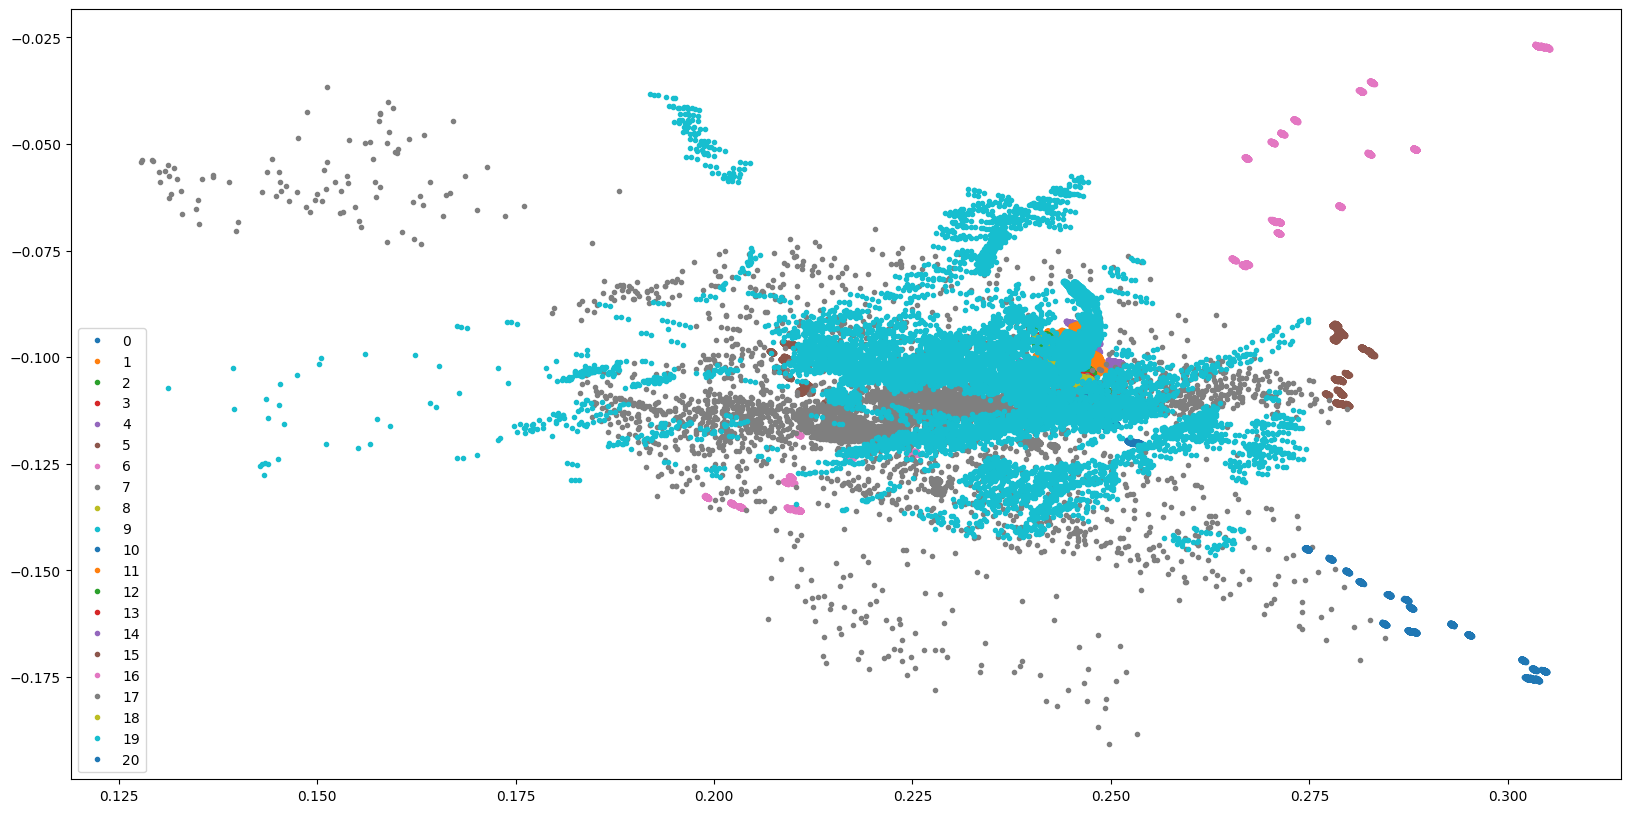

In [109]:
train_z = lda.transform(train_data)

legends = []
plt.figure(figsize=(20,10))
for i in targets:
    plt.plot(train_z[train_z['target'] == i][0],train_z[train_z['target'] == i][1],'.')
    legends.append(int(i))
plt.legend(legends)

In [110]:
# Classify each class' mean and covariance
c = {}
# train_z = train_z.astype('float') # force real
for i in targets:
    c.update({i:{
        "mean" : train_z[train_z['target']==i].drop('target',axis=1).mean().to_numpy(),
        "cov" : train_z[train_z['target']==i].drop('target',axis=1).cov().to_numpy(),
        }})

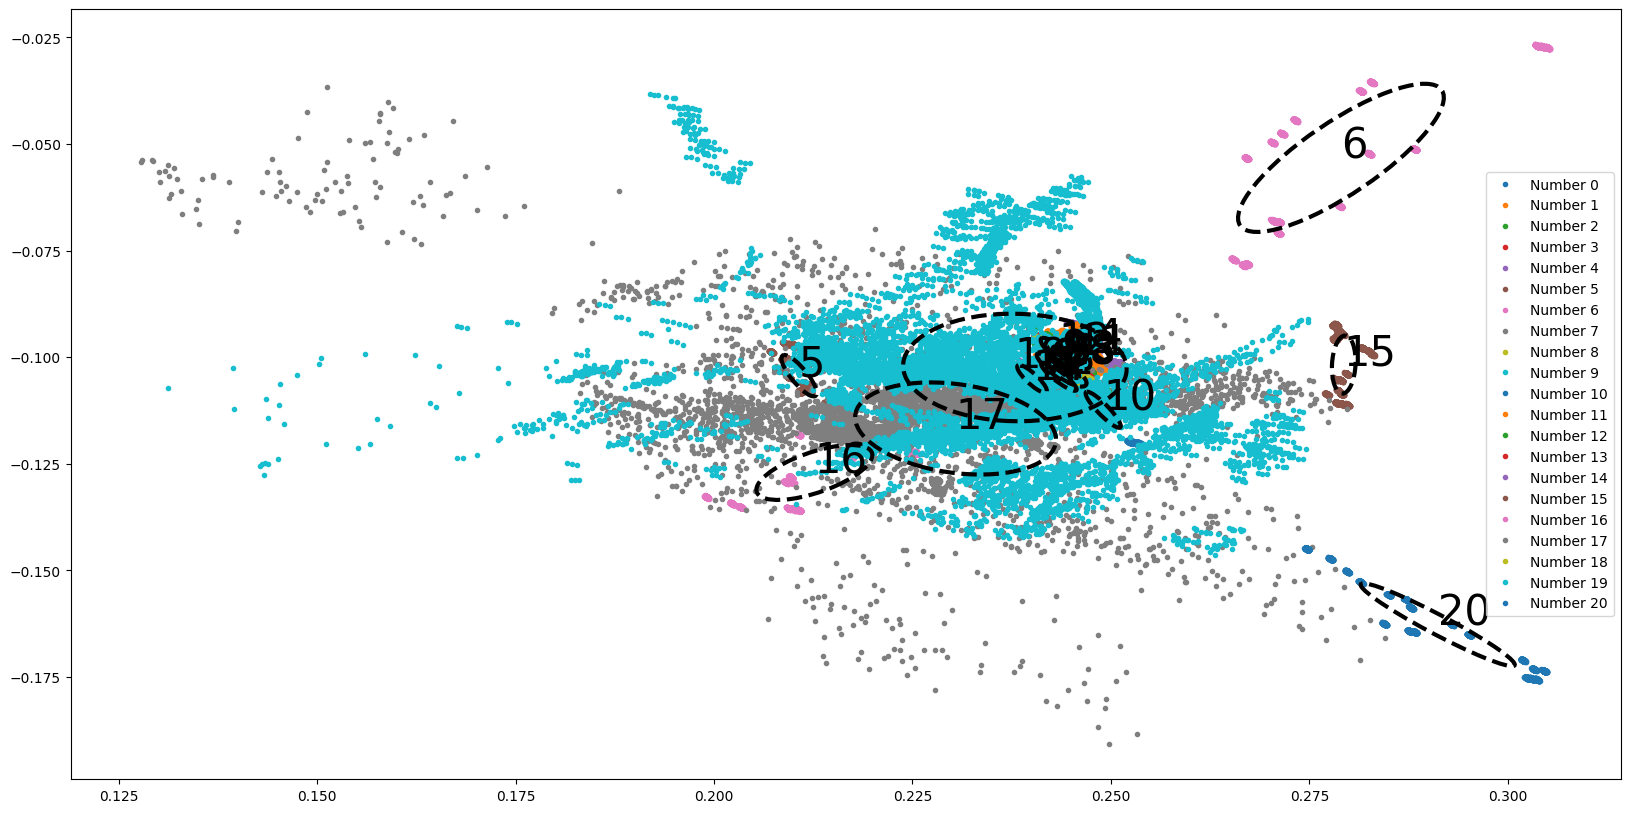

In [111]:
# Plot of training data in lower dim
import std
fig , axs = plt.subplots(figsize=(20,10))
lgnd = []
for i in targets:
    subdf = train_z[train_z['target'] == i]
    axs.plot(np.real(subdf[0]),np.real(subdf[1]),'.')
    axs.text(c[i]["mean"][0],c[i]["mean"][1],i,fontsize=30)
    lgnd.append(i)
axs.legend(["Number "+str(x) for x in lgnd ])
for i in targets:
    std.std_dev(c[i]["mean"],c[i]["cov"],1,axs)

In [118]:
from scipy.stats import multivariate_normal as mvn
from numpy import real

# Run classification
correct = [0 for x in range(len(targets))]
incorrects = []

test_z = train_z.sample(frac=0.05)

conf_matrix = np.zeros((len(targets),len(targets)))

for sample in test_z.iterrows():
    # Find the argument with the highest 
    if sample[1]['target'] in targets:
        arg = np.argmax([mvn.pdf(real(sample[1].drop('target')),real(c[n]["mean"]),real(c[n]["cov"])) for n in targets])
        guess = targets[arg]
        
        conf_matrix[targets.index(int(sample[1]['target'])),int(arg)] += 1

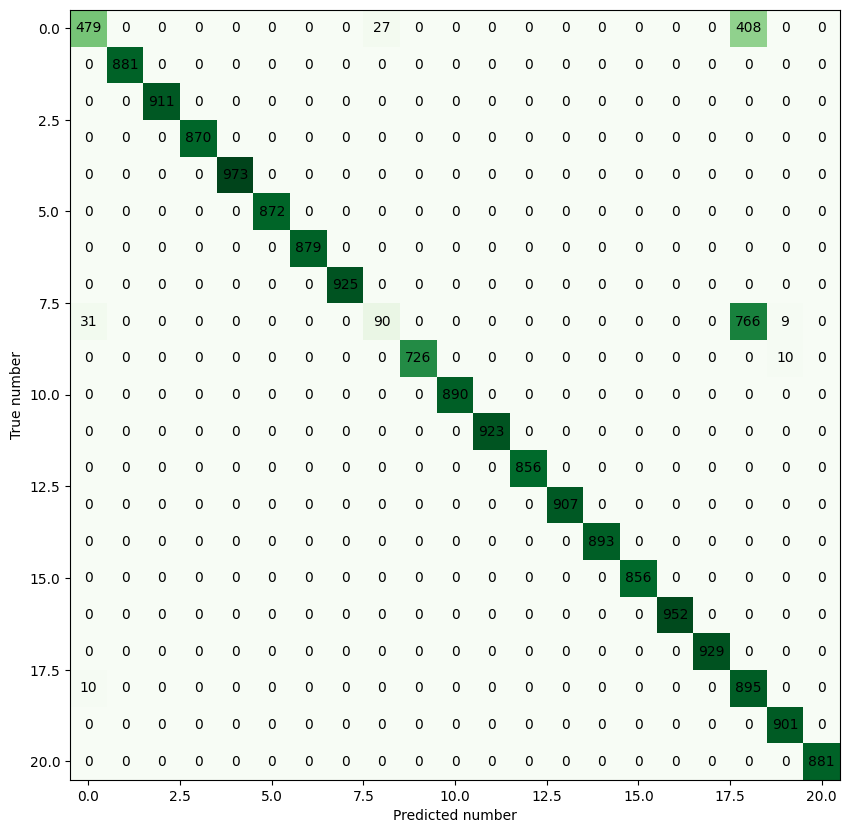

In [119]:
fig , axs = plt.subplots(figsize=(10,10))
axs.imshow(conf_matrix,cmap="Greens")
axs.set_xlabel("Predicted number")
axs.set_ylabel("True number")

width, height = conf_matrix.shape

for x in range(width):
    for y in range(height):
        axs.annotate(str(int(conf_matrix[x][y])), xy=(y, x), 
            horizontalalignment='center',
            verticalalignment='center')

In [120]:
# Print results
for i in targets:
    id = targets.index(i)
    corr = correct[targets.index(i)]
    total = len(test_z[test_z['target'] == i])
    print(f"{i} : \t{int(conf_matrix[id,id])}/{int(sum(conf_matrix[id,:]))}\t {round(conf_matrix[id,id]/sum(conf_matrix[id,:])*100,3)}%")
    
tot_corr = int(sum([conf_matrix[targets.index(x),targets.index(x)] for x in targets]))
tot = int(len(test_z))
    
print(f"TOT : \t{tot_corr}/{tot}\t {round((tot_corr/tot)*100,3)}%")

0 : 	479/914	 52.407%
1 : 	881/881	 100.0%
2 : 	911/911	 100.0%
3 : 	870/870	 100.0%
4 : 	973/973	 100.0%
5 : 	872/872	 100.0%
6 : 	879/879	 100.0%
7 : 	925/925	 100.0%
8 : 	90/896	 10.045%
9 : 	726/736	 98.641%
10 : 	890/890	 100.0%
11 : 	923/923	 100.0%
12 : 	856/856	 100.0%
13 : 	907/907	 100.0%
14 : 	893/893	 100.0%
15 : 	856/856	 100.0%
16 : 	952/952	 100.0%
17 : 	929/929	 100.0%
18 : 	895/905	 98.895%
19 : 	901/901	 100.0%
20 : 	881/881	 100.0%
TOT : 	17489/18750	 93.275%
